In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import getopt
import ast
import pickle
from sklearn.model_selection import train_test_split

import copy

In [2]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.6/248.6 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.8 MB/s eta 0:00:00


In [3]:
import wandb

# Log in to your W&B account
wandb.login()


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
# Read the data
train_data = pd.read_csv('train.csv')

# Set up the data
global X_train,y_train
#y_train = train_data['label'].values
#X_train = train_data.drop(columns=['label']).values/255

y = train_data['label'].values
X = train_data.drop(columns=['label']).values/255


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

global n_H,n,K
n_H = 256 # number of neurons in the hidden layer
n = X_train.shape[1] # number of pixels in an image
K = 10

FileNotFoundError: ignored

In [ ]:
# relu activation function
def relu(x):
    x[x<0]=0
    return x


def loss(y_pred,y_true):
    '''
    Loss function: cross entropy
    y_true: ground truth, of shape (N, )
    y_pred: prediction made by the model, of shape (N, K)
    N: number of samples in the batch
    K: global variable, number of classes
    '''

    y_true_one_hot_vec = (y_true[:,np.newaxis] == np.arange(K))
    loss_sample = (np.log(y_pred) * y_true_one_hot_vec).sum(axis=1)

    return -np.mean(loss_sample)


def feed_forward(X,W,b):
    '''
    simple FNN with 1 hidden layer
    Layer 1: input
    Layer 2: hidden layer, with a size implied by the arguments W[0], b
    Layer 3: output layer, with a size implied by the arguments W[1]
    '''
    # layer 1 = input layer
    a1 = X
    # layer 1 (input layer) -> layer 2 (hidden layer)
    z1 = np.matmul(X, W[0]) + b[0]
    # layer 2 activation
    a2 = relu(z1)
    # layer 2 (hidden layer) -> layer 3 (output layer)
    z2 = np.matmul(a2, W[1])
    s = np.exp(z2)
    total = np.sum(s, axis=1).reshape(-1,1)
    sigma = s/total
    # the output is a probability for each sample
    return sigma,a2,z1


def backprop(W,b,X,y, y_pred, a2, z1):

    N = X.shape[0]


    # layer 2->layer 3 weights' derivative
    y_one_hot_vec = (y[:,np.newaxis] == np.arange(K))
    delta2 = (y_pred - y_one_hot_vec)
    grad_W1 = np.matmul(a2.T, delta2)

    # layer 1->layer 2 weights' derivative
    # layer 2 activation's (weak) derivative is 1*(z1>0)
    delta1 = np.matmul(delta2, W[1].T)*(z1>0)
    grad_W0 = np.matmul(X.T, delta1)

    dW = [grad_W0/N , grad_W1/N ]
    db = [np.mean(delta1, axis=0)]
    # dW[0] is W[0]'s derivative, and dW[1] is W[1]'s derivative; similar for db
    return dW, db

def calculate_test_accuracy(X_test, y_test, W, b, K):
    # Perform feed-forward to get the predictions
    y_pred, _, _ = feed_forward(X_test, W, b)

    # Convert probabilities to class predictions
    class_predictions = np.argmax(y_pred, axis=1)

    # Calculate accuracy
    accuracy = np.mean(class_predictions == y_test)
    return accuracy

In [ ]:
# same initialization for SGD and NSGD
# W0 = [[1e-1*np.random.randn(n, n_H), 1e-1*np.random.randn(n_H, K)] for i in range(n_run)]
# b0 = [[np.random.randn(n_H)] for i in range(n_run)]
global W_start,b_start
W_start = [1e-1*np.random.randn(n, n_H), 1e-1*np.random.randn(n_H, K)]
b_start = [np.random.randn(n_H)]

with open("W_start", "wb") as fp: pickle.dump(W_start,fp)
with open("b_start", "wb") as fp: pickle.dump(b_start,fp)

In [ ]:
import numpy as np
import pickle

# THE USUAL SGD

def run_experiment_SGD(n_run, n_iter, batch_size, eta, X_train, y_train, X_test, y_test, K):
    # creating lists to store results
    full_loss_SGD = [[] for _ in range(n_run)]
    train_loss_SGD = [[] for _ in range(n_run)]
    test_accuracy_SGD = [[] for _ in range(n_run)]

    for r in range(n_run):
        # initialization
        with open("W_start", "rb") as fp: W = pickle.load(fp)
        with open("b_start", "rb") as fp: b = pickle.load(fp)

        for i in range(n_iter):
            # Calculate full loss and test accuracy every 5 iterations
            if (i % 5) == 0:
                y_pred, a2, z1 = feed_forward(X_train, W, b)
                full_loss_SGD[r].append(loss(y_pred, y_train))
                test_accuracy_SGD[r].append(calculate_test_accuracy(X_test, y_test, W, b, K))

            # Randomly choose samples
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            y_pred, a2, z1 = feed_forward(X_train[idx], W, b)
            train_loss_SGD[r].append(loss(y_pred, y_train[idx]))

            # Backpropagation and update weights
            dW, db = backprop(W, b, X_train[idx], y_train[idx], y_pred, a2, z1)
            W[0] -= eta * dW[0]
            W[1] -= eta * dW[1]
            b[0] -= eta * db[0]

            print("End of iteration", i)

    # Save the results to files
    with open("full_loss_SGD_batch{}_Nrun{}_eta{}".format(batch_size, n_run, eta), "wb") as fp:
        pickle.dump(full_loss_SGD, fp)
    with open("train_loss_SGD_batch{}_Nrun{}_eta{}".format(batch_size, n_run, eta), "wb") as fp:
        pickle.dump(train_loss_SGD, fp)
    with open("test_accuracy_SGD_batch{}_Nrun{}_eta{}".format(batch_size, n_run, eta), "wb") as fp:
        pickle.dump(test_accuracy_SGD, fp)

    return full_loss_SGD, train_loss_SGD, test_accuracy_SGD



In [ ]:
## NSGD with batch loss based update
def run_experiment_NSGD_batch(n_run, n_iter, batch_size, eta, X_train, y_train, X_test, y_test, K):
    # creating lists to store results
    full_loss_NSGD = [[] for _ in range(n_run)]
    train_loss_NSGD = [[] for _ in range(n_run)]
    test_accuracy_NSGD = [[] for _ in range(n_run)]

    for r in range(n_run):
        # initialization
        with open("W_start", "rb") as fp: Wn = pickle.load(fp)
        with open("b_start", "rb") as fp: bn = pickle.load(fp)

        for i in range(n_iter):
            # Calculate full loss and test accuracy every 5 iterations
            if (i % 5) == 0:
                y_pred, a2, z1 = feed_forward(X_train, Wn, bn)
                full_loss_NSGD[r].append(loss(y_pred, y_train))
                test_accuracy_NSGD[r].append(calculate_test_accuracy(X_test, y_test, Wn, bn, K))

            # Randomly choose samples
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            y_pred, a2, z1 = feed_forward(X_train[idx], Wn, bn)
            loss_xk = loss(y_pred, y_train[idx])
            train_loss_NSGD[r].append(loss_xk) # batch loss

            # Backpropagation
            dWn, dbn = backprop(Wn, bn, X_train[idx], y_train[idx], y_pred, a2, z1)

            # Update weights and biases if the new batch loss is lower
            Wnn = [Wn[0] - eta * dWn[0], Wn[1] - eta * dWn[1]]
            bnn = [bn[0] - eta * dbn[0]]
            y_pred, a2, z1 = feed_forward(X_train[idx], Wnn, bnn)
            loss_xkp1 = loss(y_pred, y_train[idx])

            if loss_xkp1 < loss_xk:
                Wn, bn = Wnn, bnn

            print('Iteration', i, '| Loss improved:', loss_xkp1 < loss_xk)

    # Save the results to files
    with open("full_loss_NSGD_batch{}_Nrun{}_eta{}".format(batch_size, n_run, eta), "wb") as fp:
        pickle.dump(full_loss_NSGD, fp)
    with open("train_loss_NSGD_batch{}_Nrun{}_eta{}".format(batch_size, n_run, eta), "wb") as fp:
        pickle.dump(train_loss_NSGD, fp)
    with open("test_accuracy_NSGD_batch{}_Nrun{}_eta{}".format(batch_size, n_run, eta), "wb") as fp:
        pickle.dump(test_accuracy_NSGD, fp)

    return full_loss_NSGD, train_loss_NSGD, test_accuracy_NSGD

In [ ]:
import numpy as np
import pickle
import copy

## NSGD with full loss based update

def run_experiment_NSGD_full(n_run, n_iter, batch_size, eta, X_train, y_train, X_test, y_test, K):
    # creating lists to store results
    full_loss_NSGD = [[] for _ in range(n_run)]
    train_loss_NSGD = [[] for _ in range(n_run)]
    test_accuracy_NSGD = [[] for _ in range(n_run)]

    for r in range(n_run):
        # initialization
        with open("W_start", "rb") as fp:
            Wn = pickle.load(fp)
        with open("b_start", "rb") as fp:
            bn = pickle.load(fp)

        for i in range(n_iter):
            # randomly choose samples
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            # perform forward pass on the mini-batch
            y_pred, a2, z1 = feed_forward(X_train[idx], Wn, bn)
            # calculate mini-batch loss for logging
            loss_xk = loss(y_pred, y_train[idx])
            train_loss_NSGD[r].append(loss_xk)


            # calculate gradients on the full set
            #dWn, dbn = backprop(Wn, bn, X_train[idx], y_train[idx], y_pred, a2, z1)
            dWn, dbn = backprop(Wn, bn, X_train[idx], y_train[idx], y_pred, a2, z1)

            # perform forward pass on the full training set
            y_pred_full, _, _ = feed_forward(X_train, Wn, bn)
            # calculate full training loss
            full_loss_xk = loss(y_pred_full, y_train)

            # tentative update of weights and biases
            Wnn = [W - eta * dW for W, dW in zip(Wn, dWn)]
            bnn = [b - eta * db for b, db in zip(bn, dbn)]

            # perform forward pass on the full training set with updated weights and biases
            y_pred_full_updated, _, _ = feed_forward(X_train, Wnn, bnn)
            # calculate full training loss after update
            full_loss_xkp1 = loss(y_pred_full_updated, y_train)

            # accept update if loss has decreased
            if full_loss_xkp1 < full_loss_xk:
                Wn, bn = copy.deepcopy(Wnn), copy.deepcopy(bnn)

            # record the full loss and test accuracy every 5 iterations
            if (i % 5) == 0:
                full_loss_NSGD[r].append(full_loss_xkp1)
                test_accuracy_NSGD[r].append(calculate_test_accuracy(X_test, y_test, Wn, bn, K))

            print('Iteration', i)
            print("Full Loss Decreased:", full_loss_xkp1 < full_loss_xk)

    # Save the results
    with open(f"full_loss_NSGD_batch{batch_size}_Nrun{n_run}_eta{eta}", "wb") as fp:
        pickle.dump(full_loss_NSGD, fp)
    with open(f"train_loss_NSGD_batch{batch_size}_Nrun{n_run}_eta{eta}", "wb") as fp:
        pickle.dump(train_loss_NSGD, fp)
    with open(f"test_accuracy_NSGD_batch{batch_size}_Nrun{n_run}_eta{eta}", "wb") as fp:
        pickle.dump(test_accuracy_NSGD, fp)

    return full_loss_NSGD, train_loss_NSGD, test_accuracy_NSGD



In [ ]:
n_iter = 500
n_run = 5
batch_size = 128
stepsize = 0.1

batch_sizes = [128]
#stepsize = 0.1


In [ ]:
import time

# timestamp for run name
name = f"run_{time.strftime('%Y%m%d_%H%M%S')}_{batch_size}_{stepsize}"

wandb.init(project='SGD vs NSGD', name=name, config={
    "n_run": n_run,
    "n_iter": n_iter,
    "batch_size": batch_size,
    "eta": stepsize
})


In [ ]:
full_loss1, train_loss1, test_accuracy1 = run_experiment_SGD(n_run, n_iter, batch_size, stepsize, X_train, y_train, X_test, y_test, K)


End of iteration 0
End of iteration 1
End of iteration 2
End of iteration 3
End of iteration 4
End of iteration 5
End of iteration 6
End of iteration 7
End of iteration 8
End of iteration 9
End of iteration 10
End of iteration 11
End of iteration 12
End of iteration 13
End of iteration 14
End of iteration 15
End of iteration 16
End of iteration 17
End of iteration 18
End of iteration 19
End of iteration 20
End of iteration 21
End of iteration 22
End of iteration 23
End of iteration 24
End of iteration 25
End of iteration 26
End of iteration 27
End of iteration 28
End of iteration 29
End of iteration 30
End of iteration 31
End of iteration 32
End of iteration 33
End of iteration 34
End of iteration 35
End of iteration 36
End of iteration 37
End of iteration 38
End of iteration 39
End of iteration 40
End of iteration 41
End of iteration 42
End of iteration 43
End of iteration 44
End of iteration 45
End of iteration 46
End of iteration 47
End of iteration 48
End of iteration 49
End of ite

In [ ]:
full_loss2, train_loss2, test_accuracy2 = run_experiment_NSGD_batch(n_run, n_iter, batch_size, stepsize, X_train, y_train, X_test, y_test, K)


Iteration 0 | Loss improved: True
Iteration 1 | Loss improved: True
Iteration 2 | Loss improved: True
Iteration 3 | Loss improved: True
Iteration 4 | Loss improved: True
Iteration 5 | Loss improved: True
Iteration 6 | Loss improved: True
Iteration 7 | Loss improved: True
Iteration 8 | Loss improved: True
Iteration 9 | Loss improved: True
Iteration 10 | Loss improved: True
Iteration 11 | Loss improved: True
Iteration 12 | Loss improved: True
Iteration 13 | Loss improved: True
Iteration 14 | Loss improved: True
Iteration 15 | Loss improved: True
Iteration 16 | Loss improved: True
Iteration 17 | Loss improved: True
Iteration 18 | Loss improved: True
Iteration 19 | Loss improved: True
Iteration 20 | Loss improved: True
Iteration 21 | Loss improved: True
Iteration 22 | Loss improved: True
Iteration 23 | Loss improved: True
Iteration 24 | Loss improved: True
Iteration 25 | Loss improved: True
Iteration 26 | Loss improved: True
Iteration 27 | Loss improved: True
Iteration 28 | Loss improved: 

In [ ]:
full_loss3, train_loss3, test_accuracy3 = run_experiment_NSGD_full(n_run, n_iter, batch_size, stepsize, X_train, y_train, X_test, y_test, K)


Iteration 0
Full Loss Decreased: True
Iteration 1
Full Loss Decreased: True
Iteration 2
Full Loss Decreased: True
Iteration 3
Full Loss Decreased: True
Iteration 4
Full Loss Decreased: True
Iteration 5
Full Loss Decreased: True
Iteration 6
Full Loss Decreased: True
Iteration 7
Full Loss Decreased: True
Iteration 8
Full Loss Decreased: True
Iteration 9
Full Loss Decreased: True
Iteration 10
Full Loss Decreased: True
Iteration 11
Full Loss Decreased: False
Iteration 12
Full Loss Decreased: True
Iteration 13
Full Loss Decreased: True
Iteration 14
Full Loss Decreased: True
Iteration 15
Full Loss Decreased: True
Iteration 16
Full Loss Decreased: False
Iteration 17
Full Loss Decreased: True
Iteration 18
Full Loss Decreased: True
Iteration 19
Full Loss Decreased: False
Iteration 20
Full Loss Decreased: False
Iteration 21
Full Loss Decreased: True
Iteration 22
Full Loss Decreased: False
Iteration 23
Full Loss Decreased: True
Iteration 24
Full Loss Decreased: True
Iteration 25
Full Loss Decreas

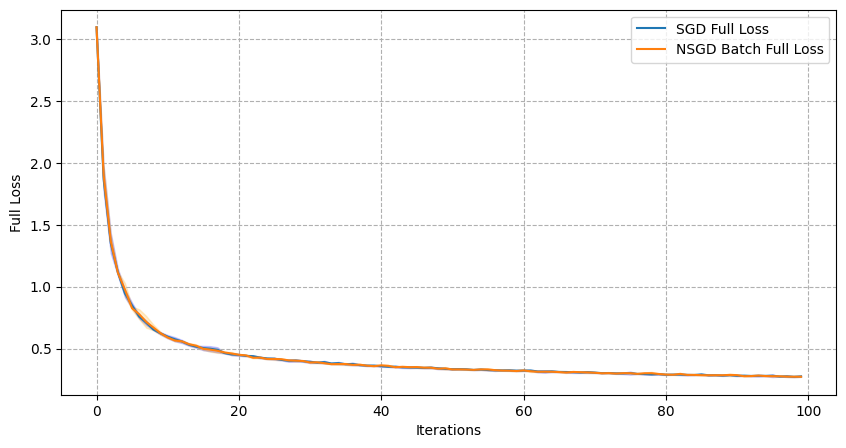

<Figure size 640x480 with 0 Axes>

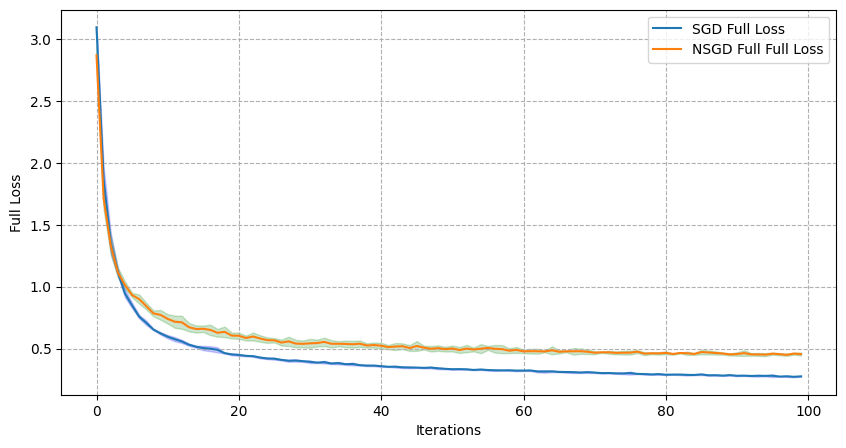

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming the following variables are defined and contain the respective results:
# full_loss1, train_loss1, test_accuracy1 for SGD
# full_loss2, train_loss2, test_accuracy2 for NSGD batch
# full_loss3, train_loss3, test_accuracy3 for NSGD full

# Plot for Full Loss (SGD vs NSGD batch)
plt.figure(figsize=(10, 5))
plt.plot(np.mean(full_loss1, axis=0), label="SGD Full Loss")
plt.fill_between(range(len(np.mean(full_loss1, axis=0))),
                 np.mean(full_loss1, axis=0) - np.std(full_loss1, axis=0),
                 np.mean(full_loss1, axis=0) + np.std(full_loss1, axis=0),
                 color='blue', alpha=0.2)
plt.plot(np.mean(full_loss2, axis=0), label="NSGD Batch Full Loss")
plt.fill_between(range(len(np.mean(full_loss2, axis=0))),
                 np.mean(full_loss2, axis=0) - np.std(full_loss2, axis=0),
                 np.mean(full_loss2, axis=0) + np.std(full_loss2, axis=0),
                 color='orange', alpha=0.2)
plt.xlabel("Iterations")
plt.ylabel("Full Loss")
plt.legend()
plt.grid(linestyle='--')
plt.savefig("full_loss_SGD_vs_NSGD_batch.png", bbox_inches='tight')
plt.show()

wandb.log({"full_loss_SGD_vs_NSGD_batch": wandb.Image(plt)})

# Plot for Full Loss (SGD vs NSGD full)
plt.figure(figsize=(10, 5))
plt.plot(np.mean(full_loss1, axis=0), label="SGD Full Loss")
plt.fill_between(range(len(np.mean(full_loss1, axis=0))),
                 np.mean(full_loss1, axis=0) - np.std(full_loss1, axis=0),
                 np.mean(full_loss1, axis=0) + np.std(full_loss1, axis=0),
                 color='blue', alpha=0.2)
plt.plot(np.mean(full_loss3, axis=0), label="NSGD Full Full Loss")
plt.fill_between(range(len(np.mean(full_loss3, axis=0))),
                 np.mean(full_loss3, axis=0) - np.std(full_loss3, axis=0),
                 np.mean(full_loss3, axis=0) + np.std(full_loss3, axis=0),
                 color='green', alpha=0.2)
plt.xlabel("Iterations")
plt.ylabel("Full Loss")
plt.legend()
plt.grid(linestyle='--')
plt.savefig("full_loss_SGD_vs_NSGD_full.png", bbox_inches='tight')
plt.show()

wandb.log({"full_loss_SGD_vs_NSGD_full": wandb.Image(plt)})



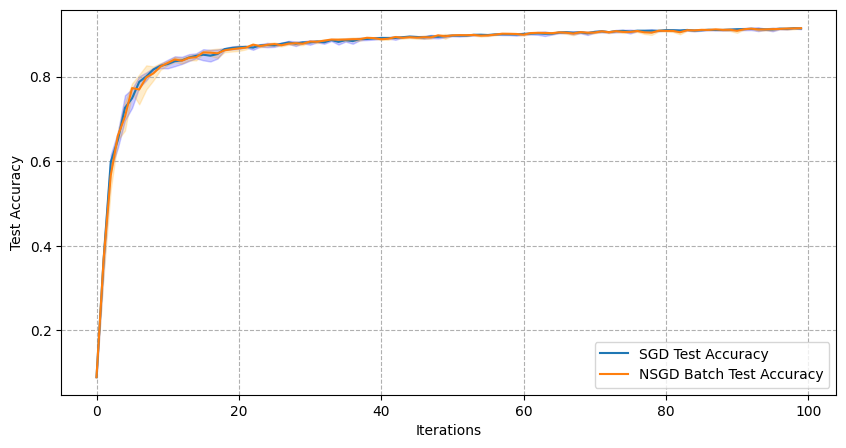

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot for Test Accuracy (SGD vs NSGD batch)
plt.figure(figsize=(10, 5))
plt.plot(np.mean(test_accuracy1, axis=0), label="SGD Test Accuracy")
plt.fill_between(range(len(np.mean(test_accuracy1, axis=0))),
                 np.mean(test_accuracy1, axis=0) - np.std(test_accuracy1, axis=0),
                 np.mean(test_accuracy1, axis=0) + np.std(test_accuracy1, axis=0),
                 color='blue', alpha=0.2)
plt.plot(np.mean(test_accuracy2, axis=0), label="NSGD Batch Test Accuracy")
plt.fill_between(range(len(np.mean(test_accuracy2, axis=0))),
                 np.mean(test_accuracy2, axis=0) - np.std(test_accuracy2, axis=0),
                 np.mean(test_accuracy2, axis=0) + np.std(test_accuracy2, axis=0),
                 color='orange', alpha=0.2)
plt.xlabel("Iterations")
plt.ylabel("Test Accuracy")
plt.legend()
plt.grid(linestyle='--')
plt.savefig("test_accuracy_SGD_vs_NSGD_batch.png", bbox_inches='tight')
plt.show()
wandb.log({"test_accuracy_SGD_vs_NSGD_batch": wandb.Image(plt)})

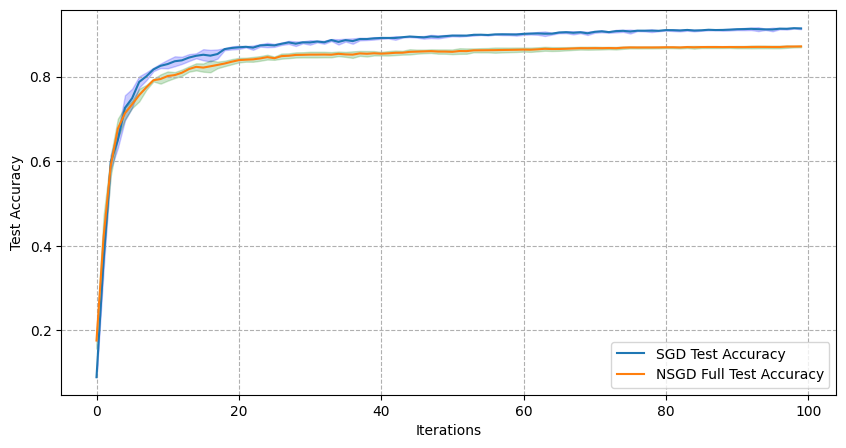

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot for Test Accuracy (SGD vs NSGD full)
plt.figure(figsize=(10, 5))
plt.plot(np.mean(test_accuracy1, axis=0), label="SGD Test Accuracy")
plt.fill_between(range(len(np.mean(test_accuracy1, axis=0))),
                 np.mean(test_accuracy1, axis=0) - np.std(test_accuracy1, axis=0),
                 np.mean(test_accuracy1, axis=0) + np.std(test_accuracy1, axis=0),
                 color='blue', alpha=0.2)
plt.plot(np.mean(test_accuracy3, axis=0), label="NSGD Full Test Accuracy")
plt.fill_between(range(len(np.mean(test_accuracy3, axis=0))),
                 np.mean(test_accuracy3, axis=0) - np.std(test_accuracy3, axis=0),
                 np.mean(test_accuracy3, axis=0) + np.std(test_accuracy3, axis=0),
                 color='green', alpha=0.2)
plt.xlabel("Iterations")
plt.ylabel("Test Accuracy")
plt.legend()
plt.grid(linestyle='--')
plt.savefig("test_accuracy_SGD_vs_NSGD_full.png", bbox_inches='tight')
plt.show()
wandb.log({"test_accuracy_SGD_vs_NSGD_full": wandb.Image(plt)})

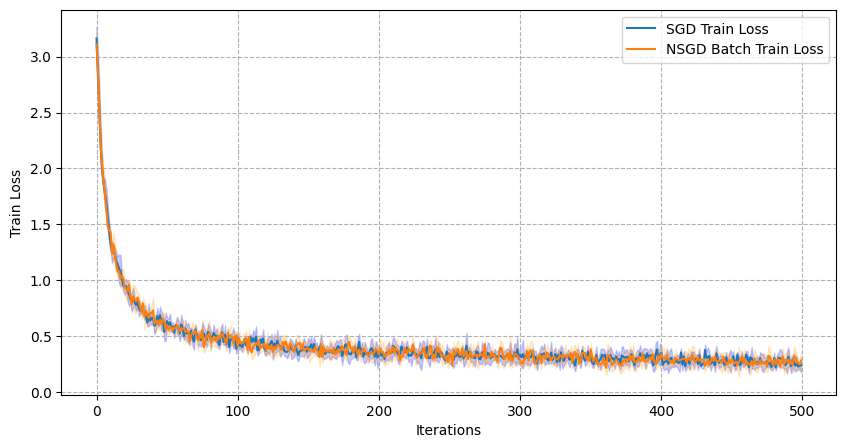

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot for Train Loss (SGD vs NSGD batch)
plt.figure(figsize=(10, 5))
plt.plot(np.mean(train_loss1, axis=0), label="SGD Train Loss")
plt.fill_between(range(len(np.mean(train_loss1, axis=0))),
                 np.mean(train_loss1, axis=0) - np.std(train_loss1, axis=0),
                 np.mean(train_loss1, axis=0) + np.std(train_loss1, axis=0),
                 color='blue', alpha=0.2)
plt.plot(np.mean(train_loss2, axis=0), label="NSGD Batch Train Loss")
plt.fill_between(range(len(np.mean(train_loss2, axis=0))),
                 np.mean(train_loss2, axis=0) - np.std(train_loss2, axis=0),
                 np.mean(train_loss2, axis=0) + np.std(train_loss2, axis=0),
                 color='orange', alpha=0.2)
plt.xlabel("Iterations")
plt.ylabel("Train Loss")
plt.legend()
plt.grid(linestyle='--')
plt.savefig("train_loss_SGD_vs_NSGD_batch.png", bbox_inches='tight')
plt.show()
wandb.log({"train_loss_SGD_vs_NSGD_batch": wandb.Image(plt)})

In [ ]:
wandb.finish()
